# Personalized Antibiogram Linear Programming

## Data Description
Here we simulate a dataset of antibiotic prescriptions, antibiotic susceptibilities, and personalized antibiogram predictions; all of which are used to perform an analysis as seen in our manuscript. The code to simulate said dataset is below (step 0 of demo), and generates a dataframe with the following column names. 

* `INFECTION_ID`: infection identifier
* `ABX_RX`: the antibiotic selected by clinicians
* `Random_ABX_RX`: randomly selected antibiotics
* `Pip_Tazo`: whether Pip-Tazo was listed as susceptible against the infection
* `Cefepime`: whether Cefepime was listed as susceptible against the infection
* `Ceftriaxone`: whether Ceftriaxone was listed as susceptible against the infection
* `Cefazolin`: whether Cefazolin was listed as susceptible against the infection
* `Pip_Tazo_predictions`: predicted probability that Pip-Tazo was listed as susceptible
* `Cefepime_predictions`: predicted probability that Cefepime was listed as susceptible
* `Ceftriaxone_predictions`: predicted probability that Ceftriaxone was listed as susceptible
* `Cefazolin_predictions`: predicted probability that Cefazolin was listed as susceptible

### Step 0: Simulate Dataset

In [1]:
### Simulate data
import pandas as pd
import numpy as np
from numpy.random import binomial, uniform, seed
from sklearn.metrics import roc_auc_score
seed(42) # for reproducibility

def simulate_predictions(labels: np.array, auroc: float) -> np.array:
    """
    Simulates an array of predictions intended to resemble personalized
    antibiogram predictions of antibiotic susceptibility on test set
    observations. Prediction array is instantiated with a random set
    of floats between 0 and 1.  Low predictions for positive labels
    are then iteratively swapped for high predictions of negative
    labels until the desired AUROC is met. 
    
    Args:
        labels: an array of labels
        auroc: desired AUROC of predictions
    Returns:
        predictions: an array of predictions
    """
    predictions = uniform(0, 1, size=labels.shape)
    auc = roc_auc_score(labels, predictions)
    pos_labels_low_pred_inds = [
        i for i in range(len(labels)) if labels[i] == 1 and predictions[i] < 0.5
    ]
    neg_labels_high_pred_inds = [
        i for i in range(len(labels)) if labels[i] == 0 and predictions[i] > 0.5
    ]
    
    counter = 0
    while auc < auroc:
        pos_ind = pos_labels_low_pred_inds[counter]
        neg_ind = neg_labels_high_pred_inds[counter]
        temp = predictions[pos_ind]
        predictions[pos_ind] = predictions[neg_ind]
        predictions[neg_ind] = temp
        auc = roc_auc_score(labels, predictions)
        counter += 1
    
    return predictions

def improve_clinician_abx_selections(df: pd.DataFrame,
    coverage_delta: float) -> pd.DataFrame:
    """
    Simulate clinician abx selections such that coverage rate exceeds
    the random coverage rate by some given delta. Coverage rate is
    the fraction of infections covered by the selected antibiotic
    
    Args:
        df: simulated data with prescriptions and labels
        coverage_delta: clinicians beat random by this amount
    Returns
        df: simulated data with enhanced clinician performance
    """
    initial_coverage_rate = np.mean([
        1 if df[df.Random_ABX_RX.values[i]][i] == 1 else 0
        for i in range(len(df)) 
    ])
    df = df.assign(ABX_RX=lambda x: [a for a in x.Random_ABX_RX])
    coverage_rate = initial_coverage_rate
    counter = 0
    while coverage_rate < initial_coverage_rate + coverage_delta:
        np.random.shuffle(df.ABX_RX.values)
        coverage_rate = np.mean([
            1 if df[df.ABX_RX.values[i]][i] == 1 else 0
            for i in range(len(df)) 
        ])
        counter += 1
        if counter % 1000 == 0:
            print(counter)
            pdb.set_trace()
    return df
        
def simulate_dataset(n=1000) -> pd.DataFrame:
    """
    Simulates a dataset with columns as described above. 
    
    Args:
        n: number of observations to simulate
    Returns:
        df: a dataframe of the simulated dataset
    """
    INFECTION_ID = [i for i in range(n)]
    
    # Assume abx follow a bernoulli distribution with varying sigma.
    # Higher the sigma, the more broad-spectrum the antibiotic is
    # ie more infections susceptible to it.
    sigma_pip_tazo = 0.95
    sigma_cefepime = 0.90
    sigma_ceftriaxone = 0.85
    sigma_cefazolin = 0.80
    
    # Simulate antibiotic susceptibility labels from specified sigmas
    Pip_Tazo = binomial(n=1, p=sigma_pip_tazo, size=(n,))
    Cefepime = binomial(n=1, p=sigma_cefepime, size=(n,))
    Ceftriaxone = binomial(n=1, p=sigma_ceftriaxone, size=(n,))
    Cefazolin = binomial(n=1, p=sigma_cefazolin, size=(n,))
    
    # Simulate a set of personalized antibiogram predictions with AUROC=0.65
    Pip_Tazo_predictions = simulate_predictions(Pip_Tazo, auroc=0.65)
    Cefepime_predictions = simulate_predictions(Cefepime, auroc=0.65)
    Ceftriaxone_predictions = simulate_predictions(Ceftriaxone, auroc=0.65)
    Cefazolin_predictions = simulate_predictions(Cefazolin, auroc=0.65)
    
    # Simulate Clinician Antibiotic Allocations
    # First randomly assign antibiotics to infections so match desired
    # distribution of antiotic selections, then perturb clinician
    # selections so that clinicians are perform slightly better than
    # random chance.
    try:
        assert n % 8 == 0
    except:
        print("n must be divisible by 8")
        raise
    abx_distribution = {
        'Pip_Tazo' : n//2,
        'Cefepime' : n//4,
        'Ceftriaxone' : n//8,
        'Cefazolin' : n//8
    }
    Random_ABX_RX = ['Pip_Tazo' for i in range(abx_distribution['Pip_Tazo'])]
    Random_ABX_RX += ['Cefepime' for i in range(abx_distribution['Cefepime'])]
    Random_ABX_RX += ['Ceftriaxone' for i in range(abx_distribution['Ceftriaxone'])]
    Random_ABX_RX += ['Cefazolin' for i in range(abx_distribution['Cefazolin'])]
    
    df = pd.DataFrame(data={
        'INFECTION_ID' : INFECTION_ID,
        'Random_ABX_RX' : Random_ABX_RX,
        'Pip_Tazo' : Pip_Tazo,
        'Cefepime' : Cefepime,
        'Ceftriaxone' : Ceftriaxone,
        'Cefazolin' : Cefazolin,
        'Pip_Tazo_predictions' : Pip_Tazo_predictions,
        'Cefepime_predictions' : Cefepime_predictions,
        'Ceftriaxone_predictions' : Ceftriaxone_predictions,
        'Cefazolin_predictions' : Cefazolin_predictions
    })
    df = improve_clinician_abx_selections(df, coverage_delta=0.02)
    
    return df

df = simulate_dataset()
df.head()

,INFECTION_ID,Random_ABX_RX,Pip_Tazo,Cefepime,Ceftriaxone,Cefazolin,Pip_Tazo_predictions,Cefepime_predictions,Ceftriaxone_predictions,Cefazolin_predictions,ABX_RX
0,0,Pip_Tazo,1,1,1,1,0.571996,0.706604,0.648257,0.533554,Pip_Tazo
1,1,Pip_Tazo,0,1,1,1,0.153900,0.535348,0.872395,0.910824,Pip_Tazo
2,2,Pip_Tazo,1,1,0,1,0.760161,0.854547,0.172386,0.831246,Cefepime
3,3,Pip_Tazo,1,1,1,1,0.805432,0.559745,0.613116,0.766768,Cefepime
4,4,Pip_Tazo,1,1,1,1,0.934433,0.869650,0.978947,0.573975,Pip_Tazo


### Step 1:  Plot Distribution of Antiobiotcs Actually Selected to Treat Patient Infections
Here we'll demonstrate how Figure generated. They are simply counts of the number of infections treated by particular antibiotic selections. 

C:\Users\DELL 5540\AppData\Local\Temp\ipykernel_2076\3681707267.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
C:\Users\DELL 5540\AppData\Local\Temp\ipykernel_2076\3681707267.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


<Axes: title={'center': 'Clinician Antibiotic Use'}, xlabel='Number of Prescriptions'>

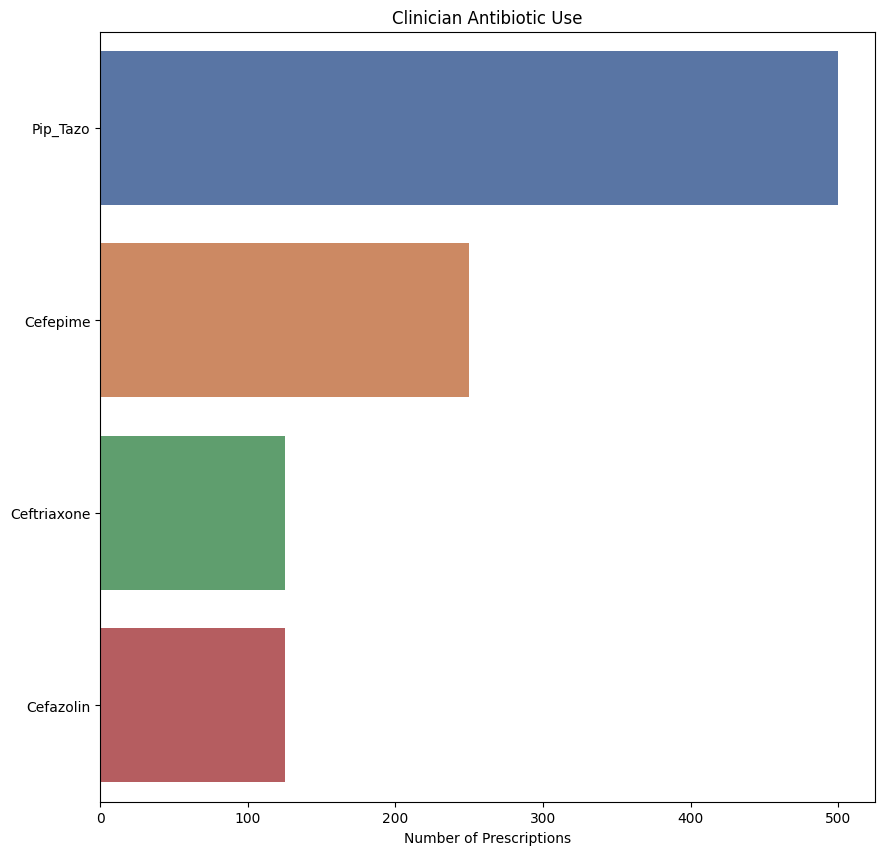

In [2]:
# Import all necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_abx_distributions(df: pd.DataFrame,
                           ax: plt.axis) -> plt.axis:
    """
    Creates a barplot that counts the number of times particular antibiotic were 
    selected by patiens to treat infections in the dataset. This function produces
    a figure that is intended to resemble Figure 2a and Figure 3a in our manuscript. 
    
    Args:
        df: simulated dataset containing abx prescriptions
        ax: axis to create plot on
    Returns:
        ax: populated axis
        
    """
    abx_distribution = df['ABX_RX'].value_counts()
    data = pd.DataFrame(data={
        'Antibiotics' : abx_distribution.index,
        'Number of Prescriptions' : abx_distribution.values
    })
    ax = sns.barplot(
        x='Number of Prescriptions',
        y='Antibiotics',
        ci=None,
        data=data,
        ax=ax,
        palette='deep',
    )
    ax.set_title("Clinician Antibiotic Use")
    ax.set_ylabel('')

    return ax

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_abx_distributions(df, ax)

### Step 2: Compute AUROC, Average Precision, and confidence intervals of Personalized Antibiogram Prediction Models
Performance of models here are meaningless as they have been simulated to achieve set performance characteristics.


In [3]:
from typing import Callable
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm

def bootstrap_performance_metric(labels: np.array,
                                 predictions: np.array,
                                 get_performance: Callable,
                                 n: int=1000) -> str:
    """
    Computes a distribution of a particular performance measure over a
    dataset by bootstrapping and returns realized and 95% confidence interval
    of measurement over said dataset
    
    Args:
        labels: ground truth labels
        predictions: model predictions over same observations
        get_performance: function that takes in labels and predictions
            and returns a performance measure ex: roc_auc_score, average_precsision
        n: number of times to bootstrap the dataset
    Returns:
        measure: a string representing actual measure and 95% confidence interval
    """
    actual_measure = get_performance(labels, predictions)
    inds = [i for i in range(len(labels))]
    measures = []
    for i in tqdm(range(n)):
        inds_b = np.random.choice(inds, size=len(inds), replace=True)
        labels_b = [labels[i] for i in inds_b]
        predictions_b = [predictions[i] for i in inds_b]
        measure = get_performance(labels_b, predictions_b)
        measures.append(measure)

    upper = round(np.percentile(measures, 97.5), 2)
    lower = round(np.percentile(measures, 2.5), 2)
    measure_ci = f"{round(actual_measure, 2)} [{lower}, {upper}]"

    return measure_ci

def generate_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes in dataset with labels and predictions for each antibiotic and
    produces a dataframe tabulating the Prevalence, AUROC, Average Precision
    and 95% confidence intervals estimate by bootstrapping the test set 1000
    times. 
    
    Args:
        df: dataframe with labels and predictions
    Returns:
        df_results: a dataframe with performance characteristics
    """
    abx_options = ['Pip_Tazo', 'Cefepime', 'Ceftriaxone', 'Cefazolin']
    prevs, aucs, aps = [], [], []
    for abx in abx_options:
        prevs.append(df[abx].mean())
        aucs.append(
            bootstrap_performance_metric(df[abx],
                                         df[f"{abx}_predictions"],
                                         roc_auc_score)
        )
        aps.append(
            bootstrap_performance_metric(df[abx],
                                         df[f"{abx}_predictions"],
                                         average_precision_score)
        )
    
    df_results = pd.DataFrame(data={
        'Antibiotic' : abx_options,
        'Prevalance' : prevs,
        'AUROC' : aucs,
        'Average Precision' : aps
    })
    
    return df_results
        
generate_table(df)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 185.33it/s]


,Antibiotic,Prevalance,AUROC,Average Precision
0,Pip_Tazo,0.954,"0.66 [0.57, 0.73]","0.97 [0.95, 0.98]"
1,Cefepime,0.903,"0.65 [0.6, 0.71]","0.94 [0.92, 0.96]"
2,Ceftriaxone,0.846,"0.65 [0.61, 0.69]","0.91 [0.89, 0.93]"
3,Cefazolin,0.804,"0.65 [0.61, 0.69]","0.88 [0.85, 0.9]"


### Step 3: Optimize Antibiotic Allocation Across Infections
Here we'll demonstrate our algorithm for optimizing antibiotic selections across a set of patients using linear programming. We create a problem formulation using the `pulp` python package and solve with the CBC solver. We then demonstrate how the antibiotic sweep plots were generated. We start with the constraint that the number of times the optimizer can select particular antibiotics must match the number of times clinicians actually selected those particular antibiotics.  Then for every pair of broader and relatively more narrow antibiotics (defined by the fraction of infections listed as susceptible to the antibiotic in the data), we iteratively perturb the optimizer constraints so that more of the narrow spectrum antibiotic and less of the broad spectrum antibiotic are selected. We iterate until all of the broader spectrum antibiotic has been replaced with the more narrow spectrum antibiotic.  We track the coverage rate (fraction of infections covered by the selected antibiotics) of the optimizer at each iteration. 

### Linear Programming Problem Formulation
Let $N$ be the number of infections in our test set who were treated with antibiotics, and let $K$ be the number of possible antibiotic selections.  Let $A$ be a matrix in $\mathbb{R}^{N\times K}$ such that $a_{ij}$ is 1 if antibiotic selection $j$ is selected to treat infection $i$ and 0 otherwise. Let $\Phi$ be a matrix in $\mathbb{R}^{N \times K}$ such that $\phi_{ij}$ is the predicted probability that antibiotic $j$ will cover infection $i$.  Let $C$ be a vector in $\mathbb{R}^K$ such that $c_j$ specifies the budget for anitbiotic selection $j$ - that is the number of times we are allowed to select antibiotic $j$ across our $N$ infections. Our problem formulation is as follows. 

$$  \underset{A}{\text{maximize}} \sum_{i=1}^{N} \sum_{j=1}^K \phi_{ij} a_{ij} $$

Subject to the following constraints:

$$ \sum_{j=1}^{K} a_{ij} = 1 \quad i = 1, ..., N $$

$$ \sum_{i=1}^{N} a_{ij} = c_j \quad j = 1, ...,  K $$

In the following code, we implenent and solve this optimization process using the pulp python package. 

In [4]:
from pulp import *
from pulp.apis import PULP_CBC_CMD

class AbxSolver():
    """
    A class for instantiating and iteratively solving optimized antibiotic
    selections problems as formulated above. 
    """

    def __init__(self, df, abx_settings):
        """
        Args
            df: dataframe of labels and predictions
            abx_settings: antibiotic budget parameters
        """
        self.df = df
        self.abx_settings = abx_settings
        self.abx_options = [key for key in abx_settings]
        self.abx_settings_copy = {
            key : self.abx_settings[key] for key in self.abx_settings
        } 
        self.n = len(df)

    def set_config(self, config_alt):
        """
        Alters config based on values in config_alt dict
        
        Args:
            config_alt: antibiotic budget parameters to set
        """
        for key in config_alt:
            self.abx_settings[key] += config_alt[key]

    def reset_config(self):
        """
        Resets config to original config
        """
        self.abx_settings = {
            key : val for key, val in self.abx_settings_copy.items()
        }

    def compute_was_covered(self, x, decision_column='ABX_RX'):
        """
        Given administered antibiotic, return whether antibiotic covered infection
        Args:
            x: dataframe row
            decision_column: column containing antibiotic selection 
        """
        if decision_column == 'Random_ABX_RX':
            med_description = x.Random_ABX_RX
        elif decision_column == 'ABX_RX':
            med_description = x.ABX_RX 
        elif decision_column == 'Optimized_ABX_RX':
            med_description = x.Optimized_ABX_RX
        else:
            raise
        return x[med_description]

    def get_coverage_rates(self, df=None):
        """
        Create flags for whether random, clinician, and optimized antibiotic
        selections coverered infections in the dataset and return fraction
        of times each covered the infection - coverag rate.
        """
        if df is None:
            df = self.df

        df = (df
            .assign(was_covered_dr=df.apply(
                lambda x: self.compute_was_covered(x), axis=1))
            .assign(was_covered_ip=df.apply(
                lambda x: self.compute_was_covered(x, 'Optimized_ABX_RX'),
                axis=1
                )
            )
            .assign(was_covered_random=df.apply(
                lambda x: self.compute_was_covered(x, 'Random_ABX_RX'),
                axis=1
                )
            )
        )

        clin_coverage_rate = df['was_covered_dr'].sum() / len(df)
        lp_coverage_rate = df['was_covered_ip'].sum() / len(df)
        random_coverage_rate = df['was_covered_random'].sum() / len(df)
        
        return clin_coverage_rate, lp_coverage_rate, random_coverage_rate

    def random_assignment(self):
        """
        Gets a random assignment of meds given current config
        """
        meds = []
        for key in self.abx_settings:
            meds += [key for i in range(self.abx_settings[key])]
        np.random.shuffle(meds)

        self.df['Random_ABX_RX'] = [m for m in meds]

    def solve_and_assign(self):
        """
        Instantiates a linear programming problem formulation using the pulp
        python package and solves with the CBC solver. Appends optimized
        antibiotic selection in to Optimized_ABX_RX column in dataframe.
        """
        # Predictions string
        predictions_string = '%s_predictions'
        abx_model = LpProblem("Antibiotics", LpMaximize)
        pdb.set_trace
        # Create binary indicators for whether treatment is used
        drug_inds = {}
        for abx in self.abx_options:
            drug_inds[abx] = [
                LpVariable('%s_%d' % (abx, i), lowBound=0, upBound=1, cat='Binary')
                for i in range(len(self.df))
            ]

        # Add objective function to model
        per_infection_sum = []
        for i in range(len(self.df)):
            _sum = 0
            for abx in self.abx_options:
                _sum += drug_inds[abx][i] * self.df[predictions_string % abx].values[i]
            per_infection_sum.append(_sum)
        abx_model += lpSum(per_infection_sum) # this is what we want to maximize

        # Add one selection constraint (only one abx option per infection)
        for i in range(len(self.df)):
            selections = []
            for abx in self.abx_options:
                selections.append(drug_inds[abx][i])
            abx_model += lpSum(selections) == 1
        
        # Add budget constraints - total number of abx selection for particular abx
        # must match fixed value specified in abx_settings.
        for drug in drug_inds:
            abx_model += lpSum(
                [drug_inds[drug][i] for i in range(len(self.df))]
            ) == self.abx_settings[drug]

        # Solve model
        abx_model.solve(solver=PULP_CBC_CMD(msg=False, timeLimit=10))

        # Save selected antibiotic to df
        abx_decisions = []
        for i in range(len(self.df)):
            abx_decision = None
            for abx in self.abx_options:
                if drug_inds[abx][i].value() == 1:
                    abx_decision = abx
            assert abx_decision is not None
            abx_decisions.append(abx_decision)
        self.df['Optimized_ABX_RX'] = abx_decisions
        

### Compare performance without perturbing antibiotic budget constraints 

In [5]:
import pdb
def get_antibiotic_coverage_rates(df: pd.DataFrame):
    """
    Instantiates a AbxSolver, solves using the same number of antiotics
    of varying types as used by clinicians. Computes coverage rate
    of a random selection, the clinician selection, and the optimized
    selection all using same antibiotic budget parameters.
    
    Args:
        df: dataframe of predictions, labels, and random and clinician
            antibiotic selections
    """
    abx_settings = df['ABX_RX'].value_counts().to_dict()
    solver = AbxSolver(df, abx_settings)
    solver.solve_and_assign()
    coverage_rates = solver.get_coverage_rates()
    print(f"Random Coverage Rate: {coverage_rates[2]}")
    print(f"Clinician Coverage Rate: {coverage_rates[0]}")
    print(f"Optimized Coverage Rate: {coverage_rates[1]}")
get_antibiotic_coverage_rates(df)

Random Coverage Rate: 0.893
Clinician Coverage Rate: 0.916
Optimized Coverage Rate: 0.958


### Sweep Budget Parameters So That Optimizer Chooses Fewer Broad-Spectrum Antibiotics
In the last portion of this demo, we'll perform several sweeps of the budget parameters to reproduce plots. Specifically, we'll showcase three sweeps where the optimizer is forced to use less of a broader spectrum antibiotic and more of a narrower spectrum antibiotic. The three tuples of (broad-specturm, more narrow-spectrum) antibiotics that we'll simulate are listed below. 
* (Pip_Tazo, Cefepime)
* (Pip_Tazo, Ceftriaxone)
* (Pip_Tazo, Cefazolin)

In each sweep, we start with budget constraints defined again by what was actually used by clinicains. Then at each iteration we force the optimizer to use one less of the broader spectrum antibiotic and one more of the more narrrow spectrum antiotic. The optimizer solves for new antibiotic allocations at each step. We keep track of the optimizers coverage rate at each step, and make sure to record the clician coverage rate and random coverage rate so that we can show where in the sweep the optimizer falls below these thresholds. 

In [6]:
from typing import List, Tuple, Dict

def sweep_opt(df: pd.DataFrame,
              sweep: Tuple[str, str],
              config: Dict[str, int]) -> Tuple[List[float], List[int],
                                               float, float]:
    """
    Performs one sweep simulation. We start using the antibiotc budget settings
    listed in config, and then iteratively perturb the settings for the antibiotics
    listed in sweep such that the optimizer is forced to use less of the broader 
    spectrum antibiotic and more of the narrower spectrum antibiotic. We track
    the coverage rate over each iteration and measure the Random, and Clinician coverage
    rate using the initial budget parameters
    
    Args:
        df: dataframe containing predictions and labels
        sweep: antibiotics to sweep over (broader, narrower)
        config: budget paramters
    Returns:
        data: tuple of lists of coverage rates and iteration number
    """
    step_size = 1
    opt = AbxSolver(df, config)
    num_replaced, o_rates = [], []
    
    # Solve with initial constraints
    opt.solve_and_assign()
    c_rate, o, r_rate = opt.get_coverage_rates()
    o_rates.append(o)
    num_replaced.append(0)
    
    for j in tqdm(range(0, config[sweep[0]], step_size)):
        opt.reset_config()
        opt.set_config({
            sweep[0] : -j,
            sweep[1] : +j
        })
        opt.solve_and_assign()
        _, o, _ = opt.get_coverage_rates()
        o_rates.append(o)
        num_replaced.append(j+1)

    data = (
        o_rates,
        num_replaced,
        c_rate,
        r_rate
    )

    return data

def perform_sweeps(df: pd.DataFrame, sweeps: List[Tuple[str, str]]) -> Dict:
    """
    Performs sweep simulations given a list of tuples representing
    which antibiotics budget parameters to sweep over.
    
    Args:
        df: dataframe with predictions and labels
        sweeps: list of tuples of antibiotics to sweep
    Returns:
        sweep_data: dictionary containing results of the sweeps
    """

    start_config = df['ABX_RX'].value_counts().to_dict()
    sweep_data = {}
    for i, sweep in enumerate(sweeps):
        sweep_data[sweep] = {}
        data = sweep_opt(df, sweep, start_config)
        
        sweep_data[sweep]['o_rates'] = data[0]
        sweep_data[sweep]['num_replaced'] = data[1]
        sweep_data[sweep]['c_rates'] = [data[2] for i in range(len(data[0]))]
        sweep_data[sweep]['r_rates'] = [data[3] for i in range(len(data[0]))]
    
    return sweep_data

sweeps = [
    ('Pip_Tazo', 'Cefepime'),
    ('Pip_Tazo', 'Ceftriaxone'),
    ('Pip_Tazo', 'Cefazolin')
]
sweep_data = perform_sweeps(df, sweeps)


100%|██████████| 500/500 [04:49<00:00,  1.73it/s]


### Plot Sweep Data
Here we demonstate how we generated Figures from the results of the sweep plot data. 

C:\Users\DELL 5540\AppData\Local\Temp\ipykernel_2076\4181841522.py:198: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([
C:\Users\DELL 5540\AppData\Local\Temp\ipykernel_2076\4181841522.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([
C:\Users\DELL 5540\AppData\Local\Temp\ipykernel_2076\4181841522.py:198: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([
C:\Users\DELL 5540\AppData\Local\Temp\ipykernel_2076\4181841522.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([
C:\Users\DELL 5540\AppData\Local\Temp\ipykernel_2076\4181841522.py:198: UserWarning: set_ticklabels() should

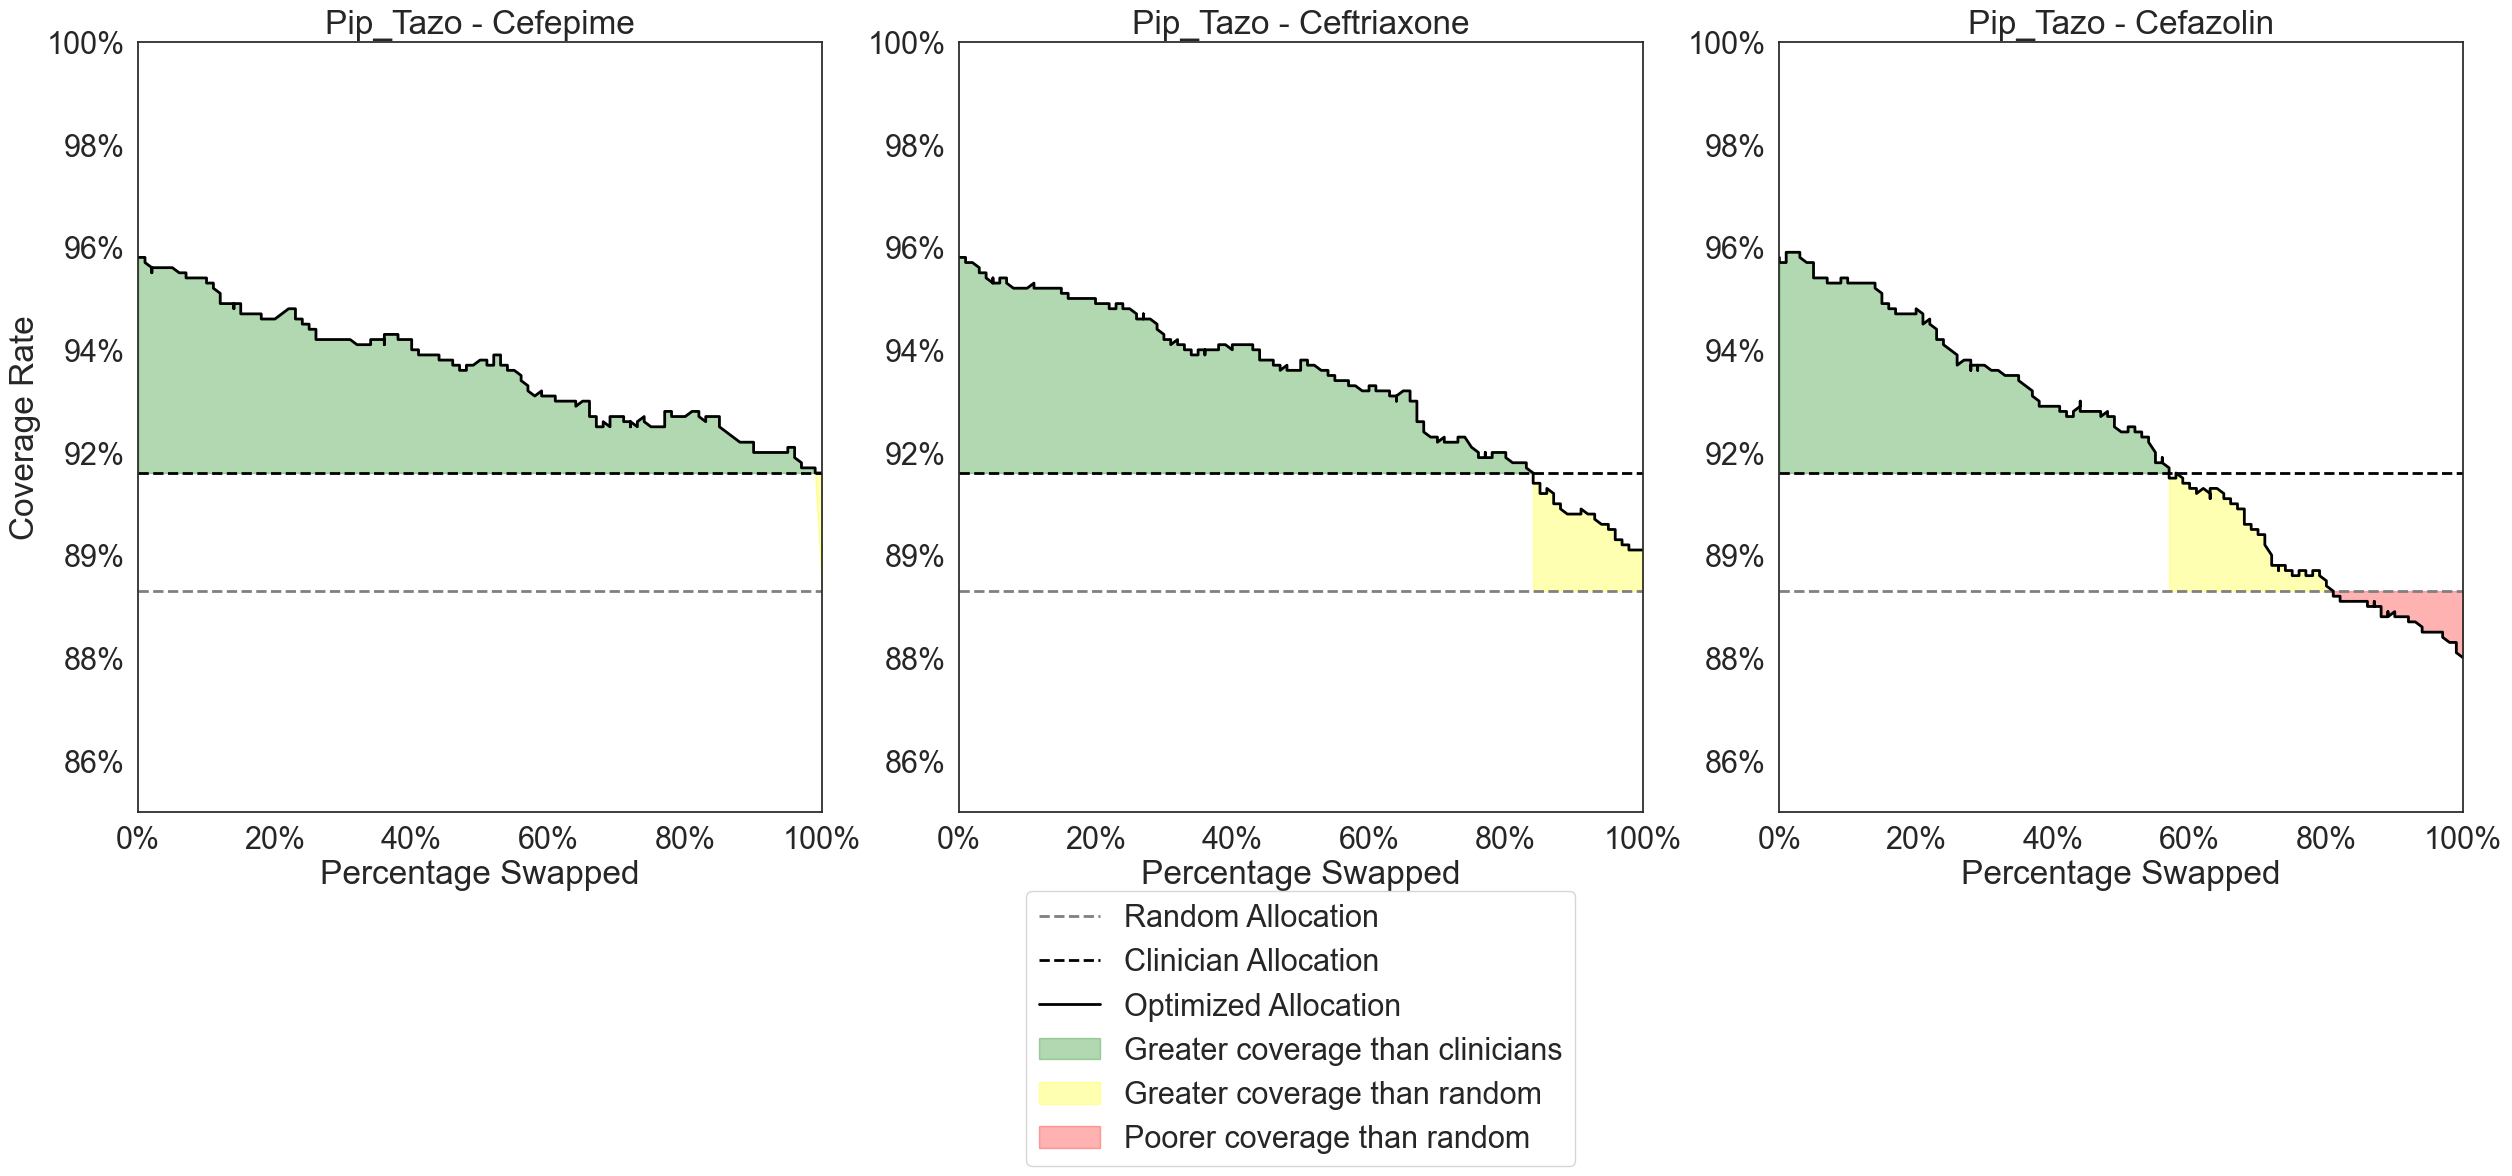

In [7]:
sns.set(style='white', font_scale=2.0)

def green(a: np.array, b: np.array, c: np.array) -> np.array:
    """
    Helper that returns array of booleans when a has yet to exceed b
    or c.
    """
    arr = a < b
    was_false = False
    for i in range(len(arr)):
        if arr[i] == False:
            was_false = True
        
        if was_false and arr[i] == True:
            arr[i] == False

    return arr

def yellow(a: np.array, b: np.array, c: np.array) -> np.array:
    """
    Helper that returns array of booleans when a has exceeded b but has yet
    to exceed c
    """
    arr = np.logical_and(
        a > b,
        a <= c
    )
    ind_first_true, ind_last_true = None, None
    was_true = False
    for i in range(len(arr)):
        if arr[i] == True and was_true == False:
            ind_first_true = i
            was_true = True
        elif arr[i] == True and was_true == True:
            ind_last_true = i

    if ind_first_true is None:
        ind_first_true = len(arr)
    if ind_last_true is None:
        ind_last_true = len(arr)

    for i in range(len(arr)):
        if i > ind_first_true-2 and i < ind_last_true:
            arr[i] = True

    return arr

def yellow_range(a: np.array, b: np.array, c: np.array) -> Tuple[int, int]:
    """
    Helper that returns range of indices where array returned by yellow is true
    """
    arr = np.logical_and(
        a > b,
        a <= c
    )
    ind_first_true, ind_last_true = None, None
    was_true = False
    for i in range(len(arr)):
        if arr[i] == True and was_true == False:
            ind_first_true = i-1
            was_true = True
        elif arr[i] == True and was_true == True:
            ind_last_true = i
    
    if ind_last_true is not None:
        if ind_last_true >= len(arr) - 2: # hack for 2nd mit plot
            ind_last_true = None

    return ind_first_true, ind_last_true

def red(a: np.array, b: np.array, c: np.array) -> np.array:
    """
    Helper that returns array of booleans when as has exceeded b and c
    """
    arr = a > c
    was_true = False
    for i in range(len(arr)):
        if arr[i] == True:
            was_true = True
        if was_true and arr[i] == False:
            arr[i] == True
    return arr


def sweep_plot(ax: plt.axis,
               sweep: Tuple[str, str],
               num_replaced: List[int],
               o_rates: List[float],
               c_rates: List[float],
               r_rates: List[float],
               params: Dict[str, int]) -> plt.axis:
    """
    Makes one sweep plot. Plots the coverage rate of the optimizer at each iteration.
    Starting on the far left of the plot we see the coverage rate where the optimizer
    was allowed to use antibiotics at the same rate clinicians used them. We then
    show how the optimizer's coverage rate changes as it is allowed a smaller and
    smaller budget of the more broad spectrum antibiotic.  As a benchmark, we plot
    the clinicians coverage rate as a dashed black line and the random coverage rate
    as a grey dashed line.  We then highlight the portion of the plot where the optimizers
    coverage rate exceeded the clinicians coverage rate in green, and when it exceeded
    the random coverage rate in yellow. 
    
    Args:
        ax: blank axis
        sweep: tuple (abx_1, abx_2)
        num_replaced: np array iteration
        o_rates: optimized coverage rates
        c_rates: clinician coverage rate
        r_rates: random coverage rate
        params: dictionary - original abx prescribing distribution
                 along with site specific data used for plot formatting

    Returns:
        ax: populated axis
    """
    percent_replaced = [
        int(n/params[sweep[0]] * 100)
        for n in num_replaced
    ]

    r_rates =  np.array(
        [params['random_rate'] for i in range(len(r_rates))]
    )
    c_rates = np.array([
        c_rates[0] for i in range(len(c_rates))
    ])
    o_rates = np.array(o_rates)

    yellow_first, yellow_last = yellow_range(o_rates, c_rates, r_rates)
    if yellow_first is not None:
        ax.vlines(
            percent_replaced[yellow_first],
            color='black',
            linestyles='dotted',
            ymin=params['ymin'],
            ymax=params['ymax']
        )
    if yellow_last is not None:
        ax.vlines(
            percent_replaced[yellow_last],
            color='black',
            linestyles='dotted',
            ymin=params['ymin'],
            ymax=params['ymax']
        )
    ax.plot(
        percent_replaced,
        r_rates,
        '--',
        label='Random Allocation',
        linewidth=2.0,
        color='grey',
    )
    ax.plot(
        percent_replaced,
        c_rates,
        '--',
        label='Clinician Allocation',
        linewidth=2.0,
        color='black',
    )
    ax.plot(
        percent_replaced,
        o_rates,
        label='Optimized Allocation',
        linewidth=2.0,
        color='black'
    )
    ax.fill_between(
        percent_replaced, o_rates, c_rates,
        where=(green(1-o_rates, 1-c_rates, 1-r_rates)),
        color='green', alpha=0.3,
        interpolate=True,
        label='Greater coverage than clinicians'
    )
    ax.fill_between(
        percent_replaced, o_rates, r_rates,
        where=(
            yellow(1-o_rates, 1-c_rates, 1-r_rates)
        ),
        color='yellow', alpha=0.3,
        interpolate=True,
        label='Greater coverage than random'
    )
    ax.fill_between(
        percent_replaced, o_rates, r_rates,
        where=(red(1-o_rates, 1-c_rates, 1-r_rates)),
        color='red', alpha=0.3,
        interpolate=True,
        label="Poorer coverage than random"
    )
    ax.set_ylim([params['ymin'], params['ymax']])
    ax.set_xlim([0, 100])
    ax.set_title(f"{sweep[0]} - {sweep[1]}")
    ax.set_xlabel(
        f"Percentage Swapped"
    )
    ax.set_xticklabels([
        f"{int(n)}%"
        for n in ax.get_xticks()
    ])
    ax.set_yticklabels([
        f"{int(n*100)}%" for n in ax.get_yticks()
    ])

    return ax


params = df['ABX_RX'].value_counts().to_dict()
params['ymin'] = 0.85
params['ymax'] = 1.0
params['random_rate'] = sweep_data[('Pip_Tazo', 'Cefepime')]['r_rates'][0]
params['site'] = 'Synthetic'
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
col = 0
for key, sweep in sweep_data.items():
    axs[col] = sweep_plot(
        axs[col],
        key,
        num_replaced=sweep['num_replaced'],
        o_rates=sweep['o_rates'],
        c_rates=sweep['c_rates'],
        r_rates=sweep['r_rates'],
        params=params
    )

    if col == 0:
        axs[col].set_ylabel("Coverage Rate")

    if col == 1:
        axs[col].legend(
            loc="lower center", bbox_to_anchor=(0.5, -0.46),
            borderaxespad=0.
        )
    col += 1      